In [27]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 10000
max_episodes = 1500

In [10]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [11]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    numsteps = []
    avg_numsteps = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                if episode % 10 == 0:                    
                    sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n"\
                                     .format(episode, np.sum(rewards), np.round(np.mean(all_rewards[-10:]), decimals = 3),  steps))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval
  
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

        
    
#   Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    #smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
    
    print(print('Varince of reward = {}'.format(np.var(all_rewards))))

episode: 0, total reward: 10.0, average_reward: 10.0, length: 9
episode: 10, total reward: 12.0, average_reward: 20.8, length: 11
episode: 20, total reward: 14.0, average_reward: 16.7, length: 13
episode: 30, total reward: 31.0, average_reward: 21.8, length: 30
episode: 40, total reward: 33.0, average_reward: 23.7, length: 32
episode: 50, total reward: 14.0, average_reward: 26.2, length: 13
episode: 60, total reward: 28.0, average_reward: 22.8, length: 27
episode: 70, total reward: 21.0, average_reward: 22.5, length: 20
episode: 80, total reward: 36.0, average_reward: 20.0, length: 35
episode: 90, total reward: 23.0, average_reward: 26.9, length: 22
episode: 100, total reward: 23.0, average_reward: 20.0, length: 22
episode: 110, total reward: 24.0, average_reward: 18.2, length: 23
episode: 120, total reward: 18.0, average_reward: 23.1, length: 17
episode: 130, total reward: 19.0, average_reward: 23.9, length: 18
episode: 140, total reward: 29.0, average_reward: 25.6, length: 28
episode

episode: 1210, total reward: 86.0, average_reward: 97.6, length: 85
episode: 1220, total reward: 200.0, average_reward: 155.5, length: 199
episode: 1230, total reward: 175.0, average_reward: 156.4, length: 174
episode: 1240, total reward: 133.0, average_reward: 125.9, length: 132
episode: 1250, total reward: 200.0, average_reward: 183.0, length: 199
episode: 1260, total reward: 200.0, average_reward: 165.0, length: 199
episode: 1270, total reward: 181.0, average_reward: 166.0, length: 180
episode: 1280, total reward: 200.0, average_reward: 137.5, length: 199
episode: 1290, total reward: 112.0, average_reward: 143.6, length: 111
episode: 1300, total reward: 151.0, average_reward: 150.3, length: 150
episode: 1310, total reward: 165.0, average_reward: 172.0, length: 164
episode: 1320, total reward: 160.0, average_reward: 170.6, length: 159
episode: 1330, total reward: 69.0, average_reward: 169.6, length: 68
episode: 1340, total reward: 200.0, average_reward: 164.8, length: 199
episode: 13

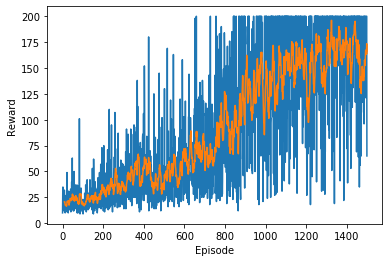

Varince of reward = 4438.8110982222215
None


In [28]:
env = gym.make("CartPole-v0")
a2c(env)   